# The Project
---

The goals/steps of this project are the following:

* Perform a Histogram of Oriented Gradient (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. Note: Normalize the features and radomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Auxiliar functions

In [1]:
import numpy as np
import cv2

def convertTime(time):
    """
    Convert time from seconds to minutes and seconds
    """
    int_time = int(time)
    m, s = divmod(int_time, 60)
    timestr = '{0}m {1}s'.format(m, s)
    return timestr

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Draw bounding boxes on a copy of the image using cv2.rectangle()
    """
    # Make a copy of the original image
    draw_img = np.copy(img)
    # For each bounding box...
    for bbox in bboxes:
        # Draw a rectangle on the "draw_img" for the bounding box "bbox"
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # return "draw_img" with the bounding boxes drawn
    return draw_img

### Data exploration

On the next cell, I explore the dataset provided on the [project repository](https://github.com/udacity/CarND-Vehicle-Detection) separating into two list (cars and notcars)

Dataset Info
Number of car images:  8792
Number of non-car images:  8968
Image size: (64, 64, 3)
Image data type: float32


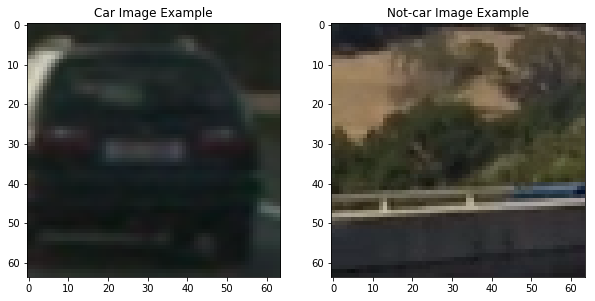

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
%matplotlib inline

cars = glob.glob('./data/vehicles/*/*.png')
notcars = glob.glob('./data/non-vehicles/*/*.png')

# Function that returns some caracteristics of the dataset
def data_look(car_list, notcar_list):
    data_dict = {}
    # Number of car images
    data_dict["n_cars"] = len(car_list)
    # Number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read a test image
    test_image = mpimg.imread(car_list[0])
    # Shape of the test_image
    data_dict["image_shape"] = test_image.shape
    # Data type of the test image
    data_dict["data_type"] = test_image.dtype
    # Return data_dict
    return data_dict

data_info = data_look(cars, notcars)

print('Dataset Info')
print('Number of car images: ', data_info["n_cars"])
print('Number of non-car images: ', data_info["n_notcars"])
print('Image size:', data_info["image_shape"])
print('Image data type:', data_info["data_type"])

# Read car and notcar images from random indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

car_image = cv2.imread(cars[car_ind])
car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)
notcar_image = cv2.imread(notcars[notcar_ind])
notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_BGR2RGB)

# Plot images
fig = plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Car Image Example')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Not-car Image Example')

### Extract Features

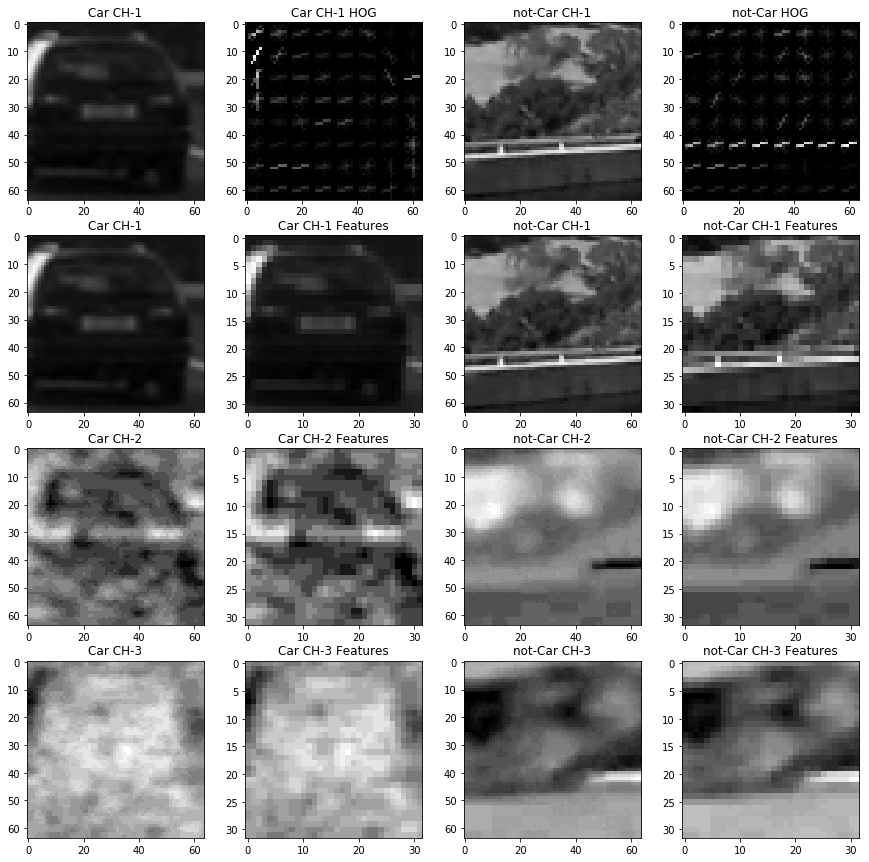

In [3]:
from skimage.feature import hog
import cv2

# Function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Create a resized feature vector
    features = cv2.resize(img, size).ravel()
    return features

# Function to extract color histogram features
# Reading .png files with cv2. So bins_range=(0, 256)
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Histogram of the color for each channel
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histogram into a feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

# Function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     transform_sqrt=True, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=transform_sqrt,
                                  visualise=True,
                                  feature_vector=False)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell), 
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=transform_sqrt, 
                       visualise=False, feature_vector=feature_vec)
        return features

# Function to extract features from a list of images
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Create a list to receive features
        img_features = []
        # Read the current image
        image = cv2.imread(file)
        # Convert to RGB color space
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Apply color conversion for the cspace parameter
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
            
        # Extract spatial features
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            img_features.append(spatial_features)
            
        # Extract color histogram features
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            img_features.append(hist_features)
        
        # Extract HOG features
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                                         orient, pix_per_cell, cell_per_block, 
                                                         vis=False, feature_vec=True))
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            img_features.append(hog_features)
            
        # Append the concatenated features to "features" list
        features.append(np.concatenate(img_features))
        
    return features

# Visualizing the features
# Call get_hog_features() with vis=True to output the hog transform image
car_newimage = cv2.cvtColor(car_image, cv2.COLOR_RGB2YUV)
notcar_newimage = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YUV)

car_hogfeatures, car_hog_image = get_hog_features(car_newimage[:,:,0], orient=9, 
                                               pix_per_cell=8, cell_per_block=2, 
                                               vis=True, feature_vec=False)
notcar_hogfeatures, notcar_hog_image = get_hog_features(notcar_newimage[:,:,0], orient=9, 
                                               pix_per_cell=8, cell_per_block=2, 
                                               vis=True, feature_vec=False)
# Channel 0
car0 = car_newimage[:,:,0]
car0 = cv2.resize(car0, (32, 32))
notcar0 = notcar_newimage[:,:,0]
notcar0 = cv2.resize(notcar0, (32, 32))

# Channel 1
car1 = car_newimage[:,:,1]
car1 = cv2.resize(car1, (32, 32))
notcar1 = notcar_newimage[:,:,1]
notcar1 = cv2.resize(notcar1, (32, 32))

# Channel 2
car2 = car_newimage[:,:,2]
car2 = cv2.resize(car2, (32, 32))
notcar2 = notcar_newimage[:,:,2]
notcar2 = cv2.resize(notcar2, (32, 32))

# Plot images
fig = plt.figure(figsize=(15, 15))
plt.subplot(4,4,1)
plt.title('Car CH-1')
plt.imshow(car_newimage[:,:,0], cmap='gray')
plt.subplot(4,4,2)
plt.title('Car CH-1 HOG')
plt.imshow(car_hog_image, cmap='gray')
plt.subplot(4,4,3)
plt.title('not-Car CH-1')
plt.imshow(notcar_newimage[:,:,0], cmap='gray')
plt.subplot(4,4,4)
plt.title('not-Car HOG')
plt.imshow(notcar_hog_image, cmap='gray')

plt.subplot(4,4,5)
plt.title('Car CH-1')
plt.imshow(car_newimage[:,:,0], cmap='gray')
plt.subplot(4,4,6)
plt.title('Car CH-1 Features')
plt.imshow(car0, cmap='gray')
plt.subplot(4,4,7)
plt.title('not-Car CH-1')
plt.imshow(notcar_newimage[:,:,0], cmap='gray')
plt.subplot(4,4,8)
plt.title('not-Car CH-1 Features')
plt.imshow(notcar0, cmap='gray')

plt.subplot(4,4,9)
plt.title('Car CH-2')
plt.imshow(car_newimage[:,:,1], cmap='gray')
plt.subplot(4,4,10)
plt.title('Car CH-2 Features')
plt.imshow(car1, cmap='gray')
plt.subplot(4,4,11)
plt.title('not-Car CH-2')
plt.imshow(notcar_newimage[:,:,1], cmap='gray')
plt.subplot(4,4,12)
plt.title('not-Car CH-2 Features')
plt.imshow(notcar1, cmap='gray')

plt.subplot(4,4,13)
plt.title('Car CH-3')
plt.imshow(car_newimage[:,:,2], cmap='gray')
plt.subplot(4,4,14)
plt.title('Car CH-3 Features')
plt.imshow(car2, cmap='gray')
plt.subplot(4,4,15)
plt.title('not-Car CH-3')
plt.imshow(notcar_newimage[:,:,2], cmap='gray')
plt.subplot(4,4,16)
plt.title('not-Car CH-3 Features')
plt.imshow(notcar2, cmap='gray')

In [4]:
import time

# Extracting features
# Parameters used on extract_features() function
color_space = 'YUV'
orient = 9 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # 0, 1, 2 or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32 # Number of histogram bins
spatial_feat = True # Spatial features
hist_feat = True # Histogram features
hog_feat = True # HOG features

# Extract features
t = time.time()
car_features = extract_features(cars, cspace=color_space, spatial_size=spatial_size, 
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, cspace=color_space, spatial_size=spatial_size, 
                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t1 = time.time()
print(convertTime(t1-t), 'to extract features...')

3m 7s to extract features...


### Normalize and Randomize data features

With the extract_features() function, I extract the features for the cars and non-cars images and then I normalize and shuffle the data.

In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time

# Scaled feature vectors
t = time.time()
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
t1 = time.time()
print(convertTime(t1-t), 'to normalize the data...')

rand_state = np.random.randint(0, 100)
t2 = time.time()
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,
                                                    test_size=0.2, 
                                                    random_state=rand_state)
t3 = time.time()
print(convertTime(t3-t2), 'to split between train and test data...')

3m 55s to normalize the data...
1m 41s to split between train and test data...


### Training the classifier

In [6]:
from sklearn.svm import LinearSVC
import time

svc = LinearSVC()
t = time.time()
svc.fit(X_train, y_train)
t1 = time.time()
print(convertTime(t1-t), 'to train SVC...')
print('Train Accuracy of classifier = ', svc.score(X_train, y_train))
print('Test Accuracy of classifier = ', svc.score(X_test, y_test))
print(svc.predict(X_test[0:10]), ' - Classifier predicts')
print(y_test[0:10], ' - Test labels')

3m 51s to train SVC...
Train Accuracy of classifier =  1.0
Test Accuracy of classifier =  0.995777027027
[ 1.  0.  1.  1.  1.  1.  0.  0.  1.  0.]  - Classifier predicts
[ 1.  0.  1.  1.  1.  1.  0.  0.  1.  0.]  - Test labels


### Detecting vehicles

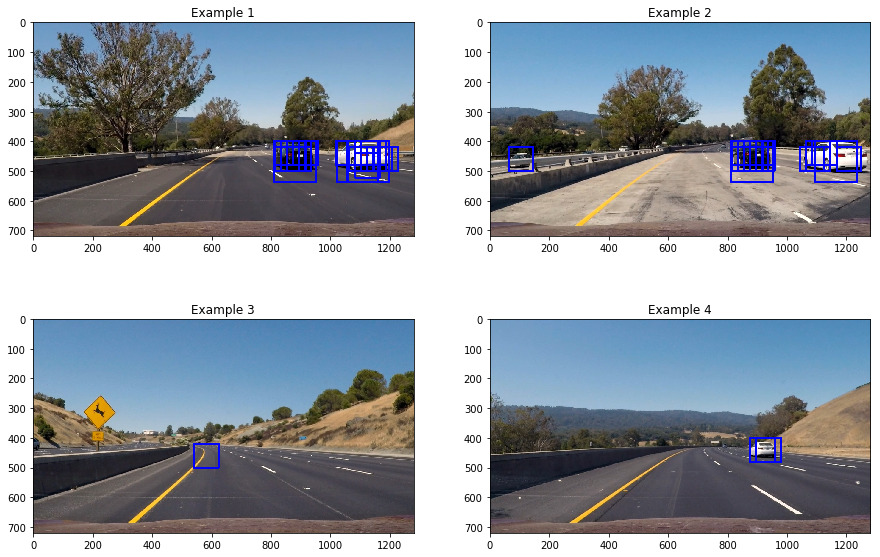

In [359]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage.measurements import label
%matplotlib inline

test_image = cv2.imread('./test_images/test6.jpg')
test_image2 = cv2.imread('./test_images/test1.jpg')
test_image3 = cv2.imread('./test_images/test2.jpg')
test_image4 = cv2.imread('./test_images/test3.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image2 = cv2.cvtColor(test_image2, cv2.COLOR_BGR2RGB)
test_image3 = cv2.cvtColor(test_image3, cv2.COLOR_BGR2RGB)
test_image4 =  cv2.cvtColor(test_image4, cv2.COLOR_BGR2RGB)

heat = np.zeros_like(test_image[:,:,0]).astype(np.float)

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64,64), xy_overlap=(0.5, 0.5)):
    # Set start and stop positions
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # num of pixels per step in x, y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # num of windows in x, y
    nx_buffer = np.int(xy_window[0]*xy_overlap[0])
    ny_buffer = np.int(xy_window[1]*xy_overlap[1])
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # List to append window positions
    window_list = []
    for y in range(ny_windows):
        for x in range(nx_windows):
            xstart = x*nx_pix_per_step + x_start_stop[0]
            xend = xstart + xy_window[0]
            ystart = y*ny_pix_per_step + y_start_stop[0]
            yend = ystart + xy_window[1]
            # Append window position to list
            window_list.append(((xstart, ystart), (xend, yend)))
    return window_list

def single_img_features(img, color_space='RGB', spatial_size=(32, 32), 
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Function to extract features from a single image window.
    """
    # Create a list to receive features
    img_features = []
    
    # Apply color conversion for the cspace parameter
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
            
    # Extract spatial features
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
            
    # Extract color histogram features
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
        
    # Extract HOG features
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                                     orient, pix_per_cell, cell_per_block, 
                                                     vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)
            
    # Append the concatenated features to "features" list
    return np.concatenate(img_features)

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                   spatial_size=(32, 32), hist_bins=32, 
                   hist_range=(0, 256), orient=9, 
                   pix_per_cell=8, cell_per_block=2, 
                   hog_channel=0, spatial_feat=True, 
                   hist_feat=True, hog_feat=True):
    # List with positive detection windows
    on_windows = []
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # Extract features
        features = single_img_features(test_img, color_space=color_space, 
                                       spatial_size=spatial_size, hist_bins=hist_bins, 
                                       orient=orient, pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        # Scale extracted features
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict using classifier
        prediction = clf.predict(test_features)
        # If it's a car, save the window
        if prediction == 1:
            on_windows.append(window)
    
    return on_windows

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    """
    Function to extract features using HOG sub-sampling and make predictions to find cars
    """
    # List with positive detection windows
    on_windows = []
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, 
                                     (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # HOG features for each channel and for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, 
                                                          hist_features, 
                                                          hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart))
                cv2.rectangle(draw_img, bbox[0], bbox[1], (0, 0, 255), 6)
                on_windows.append(bbox)
    return draw_img, on_windows
         
# Multiple detections and false positives
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add += 1 for all pixels inside each box
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    return img

# Testing the functions on the test images
ystart = 400
ystop = 670

img_boxes = np.copy(test_image)
img_boxes2 = np.copy(test_image2)
img_boxes3 = np.copy(test_image3)
img_boxes4 = np.copy(test_image4)

bboxes = []
bboxes2 = []
bboxes3 = []
bboxes4 = []
for scale in [1.3, 2.2]:
        window_img, bbox = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, 
                                      pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bboxes.extend(bbox)
for scale in [1.3, 2.2]:
        window_img2, bbox2 = find_cars(test_image2, ystart, ystop, scale, svc, X_scaler, orient, 
                                     pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bboxes2.extend(bbox2)
for scale in [1.3, 2.2]:
        window_img3, bbox3 = find_cars(test_image3, ystart, ystop, scale, svc, X_scaler, orient, 
                                       pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bboxes3.extend(bbox3)
for scale in [1.3, 2.2]:
        window_img4, bbox4 = find_cars(test_image4, ystart, ystop, scale, svc, X_scaler, orient, 
                                       pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bboxes4.extend(bbox4)

img_boxes = draw_boxes(img_boxes, bboxes, color=(0, 0, 255), thick=6)
img_boxes2 = draw_boxes(img_boxes2, bboxes2, color=(0, 0, 255), thick=6)
img_boxes3 = draw_boxes(img_boxes3, bboxes3, color=(0, 0, 255), thick=6)
img_boxes4 = draw_boxes(img_boxes4, bboxes4, color=(0, 0, 255), thick=6)
        
# Add heat to each box in box list
heat = add_heat(heat, bboxes)

# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

# Plot images
fig = plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.title('Example 1')
plt.imshow(img_boxes)
plt.subplot(222)
plt.title('Example 2')
plt.imshow(img_boxes2)
plt.subplot(223)
plt.title('Example 3')
plt.imshow(img_boxes3)
plt.subplot(224)
plt.title('Example 4')
plt.imshow(img_boxes4)

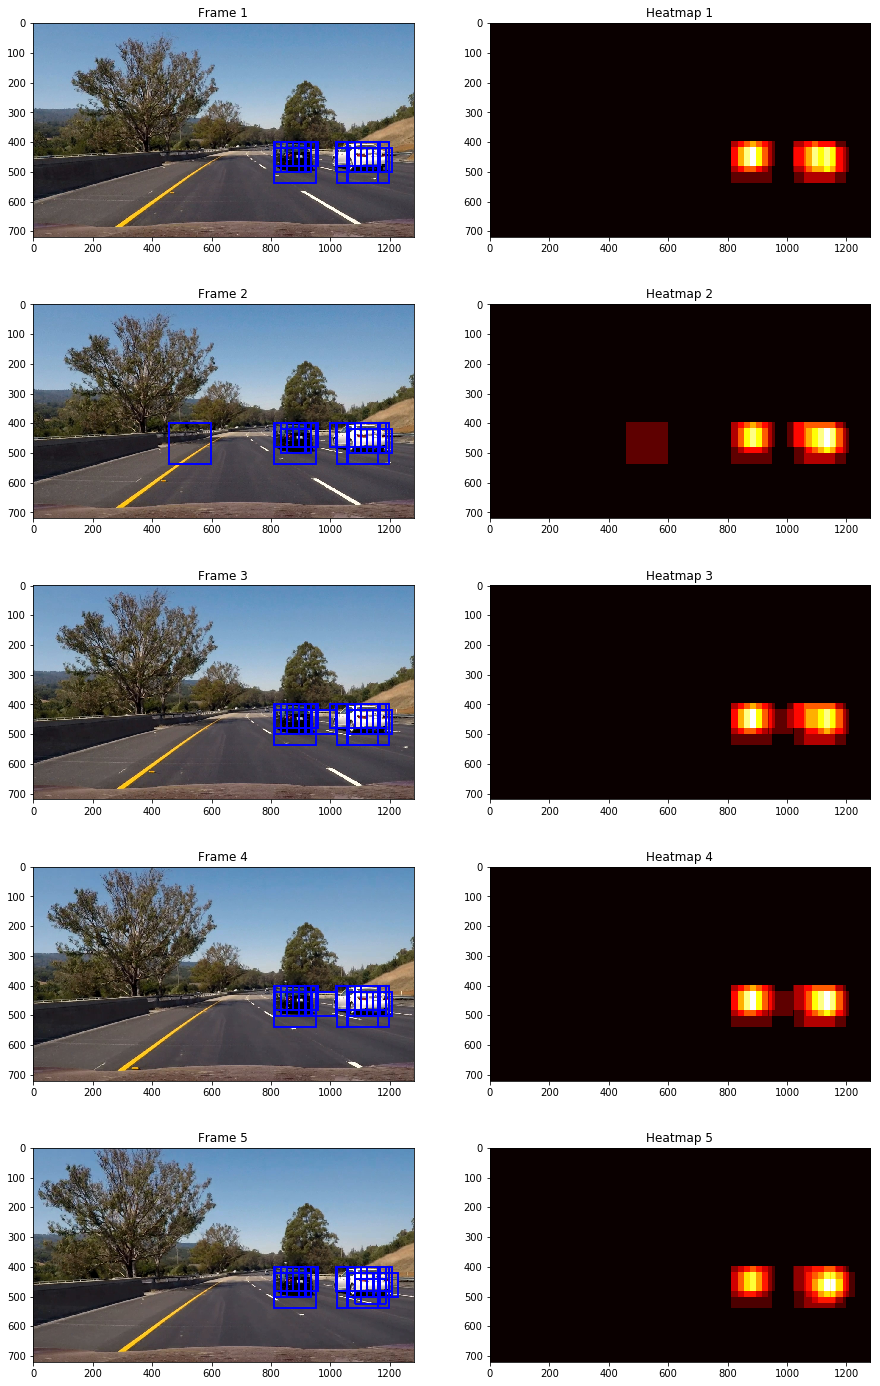

In [360]:
import glob
import cv2

frames = glob.glob('./frames/*.jpg')
img_frames = []
img_heatmaps = []
hot_bboxes = []

for frame in frames:
    bboxes = []
    heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
    img_frame = cv2.imread(frame)
    img_frameRGB = cv2.cvtColor(img_frame, cv2.COLOR_BGR2RGB)
    
    for scale in [1.3, 2.2]:
        window_img, bbox = find_cars(img_frameRGB, ystart, ystop, scale, svc, X_scaler, orient, 
                                     pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bboxes.extend(bbox)
    img_frameRGB = draw_boxes(img_frameRGB, bboxes, color=(0, 0, 255), thick=6)
    
    heat = add_heat(heat, bboxes)
    heatmap = np.clip(heat, 0, 255)
    hot_bboxes.extend(bboxes)
    img_frames.append(img_frameRGB)
    img_heatmaps.append(heatmap)
    
# Plot images
fig = plt.figure(figsize=(15, 25))
plt.subplot(5,2,1)
plt.title('Frame 1')
plt.imshow(img_frames[1])
plt.subplot(5,2,2)
plt.title('Heatmap 1')
plt.imshow(img_heatmaps[1], cmap='hot')
plt.subplot(5,2,3)
plt.title('Frame 2')
plt.imshow(img_frames[2])
plt.subplot(5,2,4)
plt.title('Heatmap 2')
plt.imshow(img_heatmaps[2], cmap='hot')
plt.subplot(5,2,5)
plt.title('Frame 3')
plt.imshow(img_frames[3])
plt.subplot(5,2,6)
plt.title('Heatmap 3')
plt.imshow(img_heatmaps[3], cmap='hot')
plt.subplot(5,2,7)
plt.title('Frame 4')
plt.imshow(img_frames[4])
plt.subplot(5,2,8)
plt.title('Heatmap 4')
plt.imshow(img_heatmaps[4], cmap='hot')
plt.subplot(5,2,9)
plt.title('Frame 5')
plt.imshow(img_frames[5])
plt.subplot(5,2,10)
plt.title('Heatmap 5')
plt.imshow(img_heatmaps[5], cmap='hot')

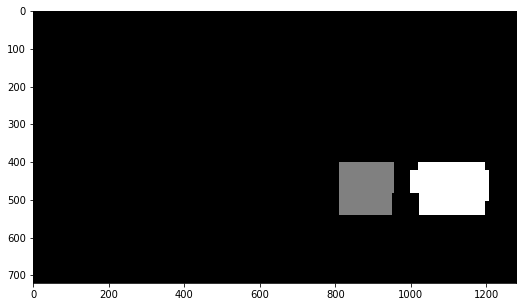

In [361]:
last_frame = cv2.imread(frames[5])
last_frame = cv2.cvtColor(last_frame, cv2.COLOR_BGR2RGB)
heat = np.zeros_like(test_image[:,:,0]).astype(np.float)

heat = add_heat(heat, hot_bboxes)
heat = apply_threshold(heat, 2)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)

# Plot images
fig = plt.figure(figsize=(10, 5))
plt.imshow(labels[0], cmap='gray')

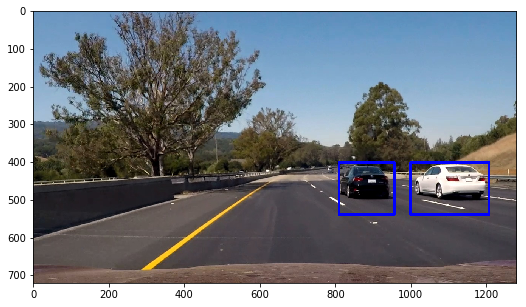

In [362]:
draw_img = draw_labeled_bboxes(np.copy(last_frame), labels)

# Plot images
fig = plt.figure(figsize=(10, 5))
plt.imshow(draw_img)

### Pipeline

In [366]:
import numpy as np

class LastBoundingBoxesQueue():
    """
    Class to record several frames before the current frame to detect
    vehicle positions and discard false positives using a heatmap
    """
    def __init__(self):
        self.max_queue = 30
        self.last_bboxes = []
        
    def insert_hot_bboxes(self, bboxes):
        if len(self.last_bboxes) >= self.max_queue:
            self.last_bboxes.pop(0)
        self.last_bboxes.append(bboxes)
        
    def get_hot_bboxes(self):
        bboxes = [] # List the last bboxes
        for boxes in self.last_bboxes:
            bboxes.extend(boxes)
        return bboxes
    
last_hot_boxes = LastBoundingBoxesQueue()

def process_frame(image):
    img = np.copy(image)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    bboxes = []
    
    for scale in [1.3, 2.2]:
        window_img, bbox = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                                     pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bboxes.extend(bbox)
        
    last_hot_boxes.insert_hot_bboxes(bboxes)
    hot_bboxes = last_hot_boxes.get_hot_bboxes()

    # Add heat to each box in box list
    heat = add_heat(heat, hot_bboxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 25)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(img, labels)
    
    return draw_img

In [367]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clip_output = 'output_videos/project_video_output.mp4'

clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_frame)
%time clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [26:24<00:01,  1.25s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

CPU times: user 25min 45s, sys: 46.5 s, total: 26min 32s
Wall time: 26min 26s


In [368]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(clip_output))